# Analysis of Variance in the Stock Market
## CSCC11 Final
### Malhar Pandya

In this case study we will be analyzing market fluctuation and attempt to categoize, interpret and predict that measure through statistical methodologies. We will perform this analysis via analysing volatility indexes such as MVIX and MEMV. Through this study we uncover amongst other things the presence of market regimes, their specifications, and hypothesise the causes for such regime switches that lead to market volatility.

We first install the required packages to perform our analysis, and set some parameters.

## Market Regimes
Let us take a look at the VIX index. We vizualise the index as a histogram to gauge the distribution of values across the given years (1990, 2019)

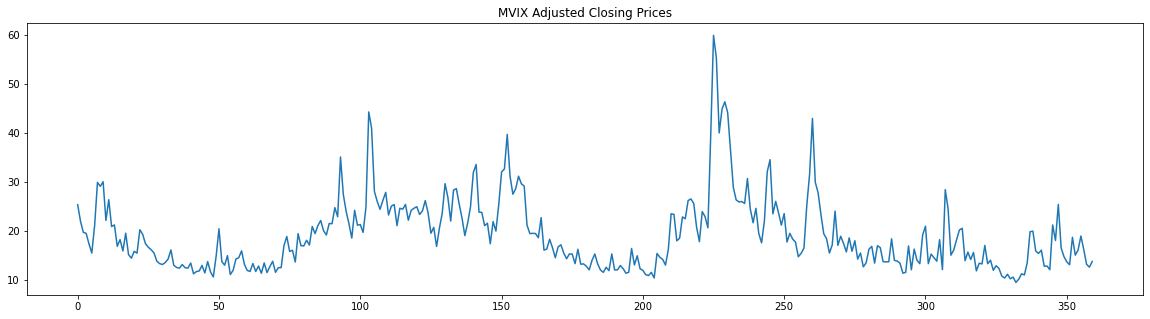

In [69]:
with open("./Datasets/MVIX.pkl", "rb") as f:
    MVIX = pickle.load(f)
N = len(MVIX)
M = 48 # Number of bins
plt.rcParams["figure.figsize"] = (20,5)
plt.title('MVIX Adjusted Closing Prices')
plt.plot(MVIX.values)
plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

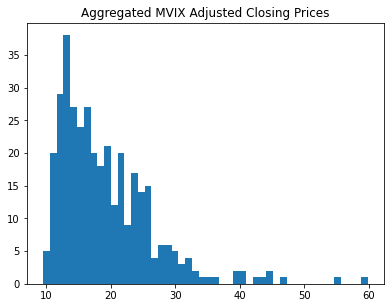

In [3]:
plt.title('Aggregated MVIX Adjusted Closing Prices')
MVIX_count, MVIX_edges, MVIX_patches = plt.hist(MVIX, bins = M)

We observe the somewhat Chi-Square like distribution of these values, as well as some potential anomalies. These values in and of its self do not serve a purpose for what we are analysing. To analyse market volatility, we should be looking at relative values (for consecutive months) of this index.

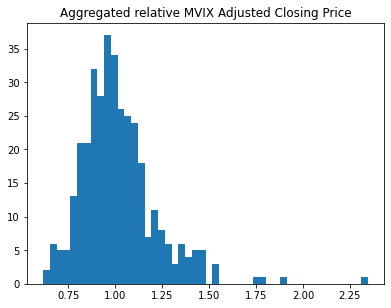

In [5]:
plt.title("Aggregated relative MVIX Adjusted Closing Price")
MVIX_rel_count, MVIX_rel_edges, MVIX_rel_patches = plt.hist(MVIX_rel, bins = M)

This looks like a better indicator, we can see that the relative index is centered around 1, indicating that for most cases, consecutive months had a similar value for the index. To further exemplify this, we centre this by means of taking the natural log.

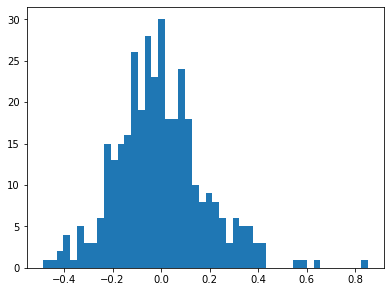

In [6]:
MVIX_log_returns = np.log(MVIX_rel)
MVIX_log_returns_count, MVIX_log_returns_edges, MVIX_log_returns_patches = plt.hist(MVIX_log_returns, bins = M)

For this study, we will use a genetic algorithm to iterate to the best possible mixture. To make sure we do not fall into a local minima, such as one of the anomalies we temporarily rid the data of the anomalous values above 0.5

In [20]:
log_returns = MVIX_log_returns[(MVIX_log_returns <= 0.5)]
N = len(log_returns)

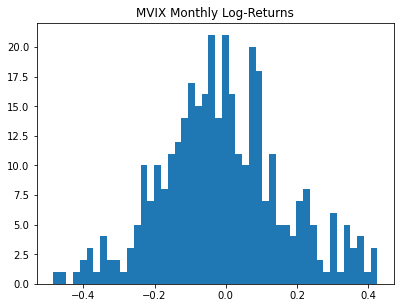

In [8]:
plt.title("MVIX Monthly Log-Returns")
log_returns_count, log_returns_edges, log_returns_patches = plt.hist(log_returns, bins = M)

We have now sufficiently transformed our data to be able to use it for analysis. An added benefit of this transformation is that the monthly log returns of this index are regarded to have a normal distribution (A mixture to be precise) and are used as a measure for market volatility. So if we can identify the mixture of gaussians the given sample is most likely to arise from, we can identify the types of regimes (the number of mixtures), their prevalence in the given sample (mixture proportions) and the general market sentiment associated with them.

We set the parameters for the algorithm based on the observed sample distribution and find optimal gaussian mixtures of size 2 to 5. We do not check for a singular mixture as that serves no purpose to the question we are attempting to answer.

We now overlay these distributions to guage their accuracy

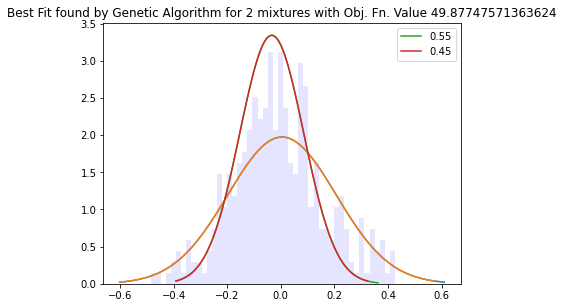

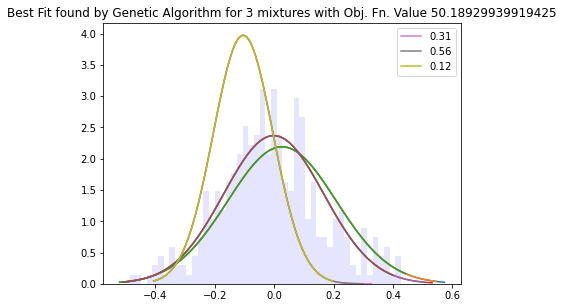

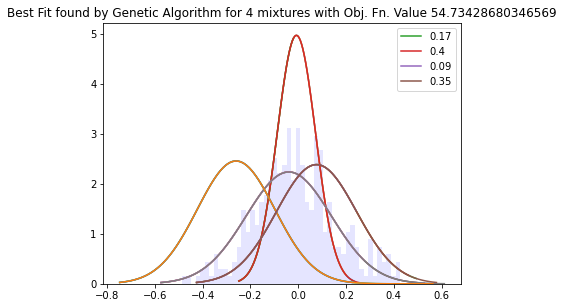

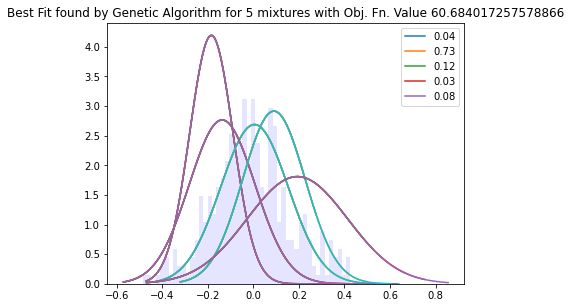

In [18]:
data = optimizer.data
for K in range(2, 6):
    mu, sigma, pi = data[K]['mean'], data[K]['variance'], data[K]['proportion']
    fit = data[K]['fit'][0]
    title = "Best Fit found by Genetic Algorithm for {} mixtures with Obj. Fn. Value {}".format(K, fit)
    plt.title(title)
    plt.hist(log_returns, bins=M, density=True, alpha=0.1, color='b')
    for i in range(K):
        x = np.linspace(mu[i] - 3*sigma[i], mu + 3*sigma[i], 100)
        plot = plt.plot(x, stats.norm.pdf(x, mu[i], sigma[i]))
        plt.legend(plot, round(pi, 2))
    plt.show()

In [13]:
for K in range(2, 6):
    print(data[K])

       mean  variance  proportion        fit
0  0.004429   0.20202    0.551245  49.877476
1 -0.033909   0.11933    0.448509  49.877476
       mean  variance  proportion        fit
0  0.026273  0.182106    0.314061  50.189299
1 -0.001706  0.168366    0.564072  50.189299
2 -0.104484  0.100394    0.121868  50.189299
       mean  variance  proportion        fit
0 -0.007637  0.080277    0.172389  54.734287
1 -0.039542  0.178320    0.395898  54.734287
2 -0.260013  0.162402    0.085520  54.734287
3  0.076497  0.167334    0.346394  54.734287
       mean  variance  proportion        fit
0 -0.184393  0.095174    0.041697  60.684017
1  0.004868  0.148484    0.725991  60.684017
2 -0.136991  0.144340    0.119995  60.684017
3  0.090311  0.136960    0.032540  60.684017
4  0.193179  0.220605    0.079730  60.684017


We can identify that just having 2 Gaussians (Regimes) is sufficient enough to satisfactorily explain the market volatility, or at least, better than having a greater number of Gaussians. We attempt to validate this by performing
a chi squared test on each solution we generated.

In [15]:
p_value

{2: 0.09045437849996121,
 3: 0.024521347660602696,
 4: 0.03636661527424162,
 5: 0.001808360084332948}

We can observe that other than the mixture with 2 components, we can reject all other component sizes as their p-values are less than the standard level of significance (0.05).

We now focus only on this 2-component mixture. Foremost, we realize that we can categorise these 2 regimes into bullish (regime 1, positive log return mean value) and bearish (regime 2, negative log return mean value) market sentiments. Additionally, the bullish regime has almost twice the volatility (variance) as the bearish regime.

We now investigate the probability of regime switching with the goal to hypothesize what might cause such regime switches. We do this by first identifying what regime each log-return belongs to, by comparing the conditional probability that the observation arised from a specific component. The largest such probability will be the component (Regime) we assign to that observation. We can then simply generate the count of transitions and generate a transition matrix.

In [46]:
Transition_Matrix

array([[0.42424242, 0.57575758],
       [0.4973545 , 0.5026455 ]])

We observe that regime switching between consecutive months is almost a 50-50 probability if the current regime is bearish but the current market regime being bullish indicates a higher tendency to move to the bearish regime. This makes sense from a intuitive perspective due to the higher volatility during that regime.

We finally conclude with some hopytheses as to what might cause such regime switches. Intuitively, these are most likely to be caused by significant changes to policies, regulations and political/commercial decisions becoming public. This inference, if used maliciously leads to what is known as insider trading. Although illegal, it has been prevalent (primarily amongst members of congress) for a long time. 

In [1]:
# Installs required for running GeneticAlgorithm
# pip install OppOpPopInit
# pip install func_timeout

# Required Imports
from IPython.utils import io
import _pickle as pickle
import numpy as np
import pandas as pd
from statistics import NormalDist
import scipy.stats as stats
import matplotlib.pyplot as plt
from genetic_algorithm import GeneticAlgorithm as ga

In [4]:
MVIX_rel = []
for i in range(1, N):
    MVIX_rel.append(MVIX['Adj Close'][i]/MVIX['Adj Close'][i-1])

In [9]:
class MoGOptimizer:
    def __init__(self):
        self.p_hat = log_returns_count/N
    # optimization function
    def lagrangean(self, theta):
        # split the variables
        K = (len(theta)-1)//3
        mu, sigma, pi, lmbda = theta[:K], theta[K:2*K], theta[2*K:3*K], theta[-1]
        # create distributions for each K
        Dist = []
        for i in range(K):
            Dist.append(NormalDist(mu[i], sigma[i]))
        # obtain theoretical probabilities (p_j)
        self.p = []
        for j in range(M):
            count = 0.0
            for i in range(K):
                count += pi[i] * (Dist[i].cdf(log_returns_edges[j+1]) - Dist[i].cdf(log_returns_edges[j]))
            self.p.append(count)
        count = 0.0
        for j in range(M):
            if self.p_hat[j] > 0.0 and self.p[j] > 0.0:
                count += self.p_hat[j] * (np.log(self.p[j]/self.p_hat[j]))
        return (-2 * N * count) + (lmbda * abs(sum(pi)-1))
    def run_optimizer(self):
        #set parameters for genetic algorithm
        algorithm_param = {'max_num_iteration': 500,\
                           'population_size':100,\
                           'mutation_probability':0.1,\
                           'elit_ratio': 0.01,\
                           'crossover_probability': 0.5,\
                           'parents_portion': 0.3,\
                           'crossover_type':'uniform',\
                           'max_iteration_without_improv':None}
    
        # Iterate through possible number of mixtures:
        self.data = {}
        for K in range(2, 6):
            print("generating optimal mixture for {} components".format(K))
            mu_bound = 1
            var_bound = 1
            lmbda_lower = 1e+3
            lmbda_upper = 1e+6
            varbound = np.array([[-mu_bound, mu_bound]]*K + [[1e-6, var_bound]]*K + [[1e-6, 1]]*K + [[lmbda_lower, lmbda_upper]])
            self.model = ga(function=self.lagrangean, dimension=3*K+1,\
                       variable_type='real',\
                       variable_boundaries=varbound,
                       algorithm_parameters=algorithm_param,
                       convergence_curve = False)
            with io.capture_output() as captured:
                print("I will not be printed.")
                self.model.run()
            theta = self.model.best_variable
            mu, sigma, pi, lmbda = theta[:K], theta[K:2*K], theta[2*K:3*K], theta[-1]
            data = pd.DataFrame({'mean': mu, 'variance': sigma, 'proportion': pi, 'fit': self.model.best_function - lmbda * (sum(pi) - 1)})
            self.data[K] = data
        return

In [10]:
optimizer = MoGOptimizer()

In [11]:
optimizer.run_optimizer()

generating optimal mixture for 2 components
generating optimal mixture for 3 components
generating optimal mixture for 4 components
generating optimal mixture for 5 components


In [14]:
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
p_value = {}
observed = log_returns_count
edges = log_returns_edges
for K in range(2, 6):
    total = 0.0
    mu, sigma, pi = data[K]['mean'], data[K]['variance'], data[K]['proportion']
    expected = [0]*M
    for i in range(K):
        ND = NormalDist(mu[i], sigma[i])
        expected_from_mixture = []
        for j in range(M):
            val = pi[i] * N * (ND.cdf(edges[j+1])*1e+6 - ND.cdf(edges[j])*1e+6) * 1e-6
            expected_from_mixture.append(val)
        expected = np.add(expected, expected_from_mixture)
    for j in range(M):
        if expected[j] > 0.0:
            total += (observed[j] - expected[j]) ** 2 / expected[j]
    p_value[K] = stats.chisqprob(total, M - (3 * K) - 1)
    

In [45]:
model = data[2]
regimes = []
mu, sigma, pi = model['mean'], model['variance'], model['proportion']
ND_1 = NormalDist(mu[0], sigma[0])
ND_2 = NormalDist(mu[1], sigma[1])
for i in range(N):
    if pi[0] * ND_1.pdf(log_returns[i]) > pi[1] * ND_2.pdf(log_returns[i]):
        regimes.append(0)
    else: regimes.append(1)
# Transition Counts
Transition_Matrix = np.zeros((2, 2))
for i in range(1, len(regimes)):
    Transition_Matrix[regimes[i-1]][regimes[i]] += 1
Transition_Matrix = Transition_Matrix/Transition_Matrix.sum(axis=1)[:,None]

# Causal Factors for Market Volatility
Now we take a look at dense set of measures in an effort to identify if some or all of those measures are correlated (to some extent) to the fluctuations and volatility observed in the Stock Market. We do so by performing a regression on the CBOE VIX index (monthly), which is considered to be a good measure for the implied volatility of the equity market. The features we use to regress are publicly available EMV trackers (monthly) which are further category constrained.

In [204]:
with open("./Datasets/MEMV.pkl", "rb") as f:
    MEMV=pickle.load(f)
N = len(MEMV)

# Exploratory Data Analysis

In [205]:
MEMV.isnull().values.any() #check for missing values

False

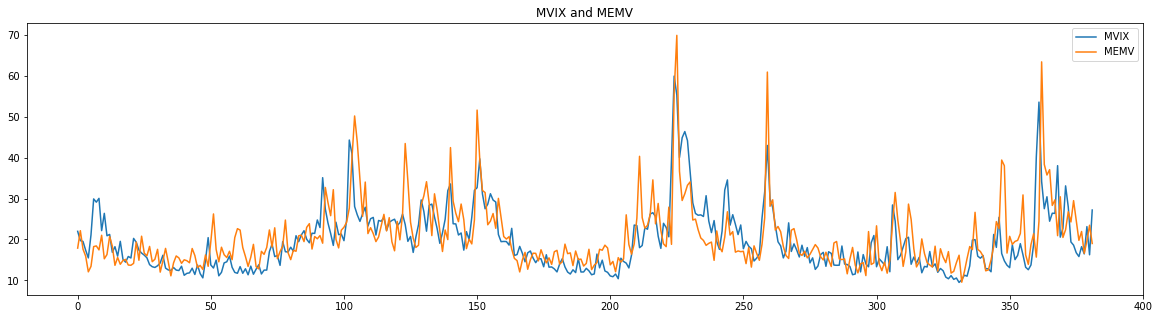

In [206]:
plt.rcParams["figure.figsize"] = (20,5)
plt.title('MVIX and MEMV')
plt.plot(MEMV['VIX'].values)
plt.plot(MEMV['EMV'].values)
plt.legend(["MVIX", "MEMV"])
plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

From the graph above we can infer that firstly, EMV is a good feature to predict values of VIX. Additionally, we can also observe that fluctuations in MEMV are
1. More pronounced than those of VIX
2. Frequently occur prior to corresponding fluctuations in MVIX

This is enough evidence to proceed to generating a regression model.

# Model Generation

For generating the regression models, we use scikit-learn, a machine learning tool designed for analysis. Using this we firstly split the data into train and test tests, train the model and analyse its accuracy by comparing the predictions of the test input with the true expected output.

We will be trying 4 different linear regression models:
1. OLS - this is the oldest and most common linear regression model. Advancements have been made to counter multicollinearity among features in other models, which makes it obsolete. Outliers skew this model significantly.
2. Ridge - This model counters multicollinearity via L2 regularization, but this leads to an increase in bias. It also required additional hyperparameter tuning.
3. Lasso - This model performs regularization and helps simplify the model by selecting a subset of features to find coefficients for. The remaining features have their coefficient set to 0.
4. Elastic Net - This is a combination of Ridge and Lasso Regression, which makes it a jack-of-all-trades kind of model. It performs well on most datasets and returns a simple model which is easy to interpret and extrapolate from.

The model we select will be based on how well it performs on the test set, and how simple it is to interpret.

In [207]:
# Importing additional packages
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from sklearn import datasets, linear_model, metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

In [208]:
np.random.seed(100)
y = MEMV["VIX"]
X = MEMV.drop("VIX", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

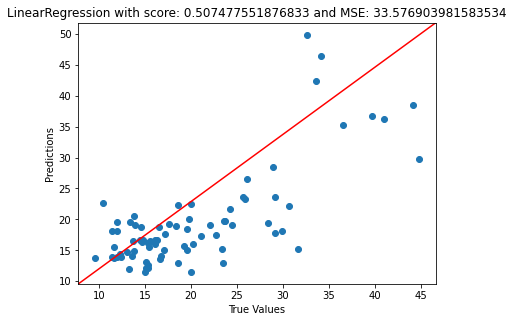

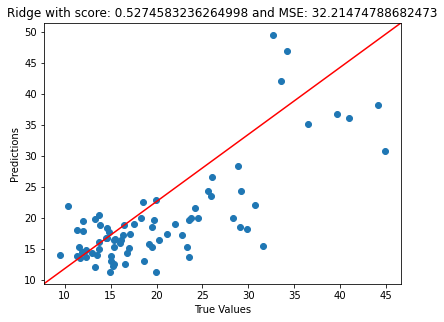

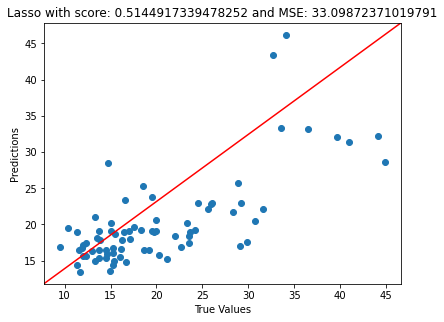

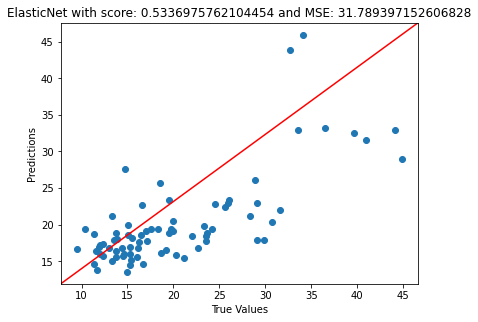

In [209]:
OLS = linear_model.LinearRegression()
RIDGE = linear_model.Ridge(alpha=0.8)
LASSO = linear_model.Lasso(alpha=0.8)
ELASTICNET = linear_model.ElasticNet(random_state=0)
for model in (OLS, RIDGE, LASSO, ELASTICNET):
    # fit the model and predict the test set
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    score = model.score(X_test, y_test)
    MSE = metrics.mean_squared_error(y_test, predictions)
    # scatterplot between predicted and true values in the test set
    title = str(type(model)).split('.')[-1][:-2] + " with score: {} and MSE: {}".format(score, MSE)
    fig, ax = plt.subplots()
    ax.scatter(y_test, predictions)
    line = mlines.Line2D([0, 1], [0, 1], color='red')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    plt.title(title)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.show()

# Model Selection

Additionally, we perform cross-validation to ensure these scores are not coincidental and the model actually does perform as well as the score says it does.

In [210]:
for model in (OLS, RIDGE, LASSO, ELASTICNET):
    scores = cross_val_score(model, X, y, cv=6) #6-fold cross validation
    scores = np.around(scores, 2)
    print ("Cross-validated scores: {}".format(scores))

Cross-validated scores: [-0.47 -0.11  0.4   0.18 -0.   -8.78]
Cross-validated scores: [-0.39 -0.04  0.41  0.24  0.08 -8.46]
Cross-validated scores: [0.18 0.29 0.51 0.5  0.32 0.21]
Cross-validated scores: [0.17 0.25 0.5  0.5  0.35 0.24]


These scores are actually coefficients of determination.
Higher values on average imply a better model fit. With this in mind, we would choose ELASTICNET as our model of choice as not only does it perform quite well, the performance is good on average as well (unlike RIDGE).
We should also take a look at the generated coefficients to identify if we can choose a simpler model but only take a slight hit in terms of predictive accuracy.

In [214]:
c = {}
names = []
for model in (OLS, RIDGE, LASSO, ELASTICNET):
    model_name = str(type(model)).split('.')[-1][:-2]
    names.append(model_name)
    c[model_name] = pd.DataFrame(model.coef_)
coefficients = pd.concat([c['LinearRegression'], c['Ridge'], c['Lasso'], c['ElasticNet']], axis=1)
coefficients.index = X_train.columns
coefficients.columns = names

In [215]:
coefficients

,LinearRegression,Ridge,Lasso,ElasticNet
EMV,-0.365766,-0.244020,0.831168,0.753739
Political Uncertainty Tracker,1.198551,1.057087,0.000000,0.000000
Infectious Disease EMV Tracker,0.130973,0.119284,-0.016042,-0.009063
Macroeconomic News and Outlook EMV Tracker,1.400069,1.275522,0.000000,0.085601
Macro – Broad Quantity Indicators EMV Tracker,0.022203,0.055196,0.000000,0.000000
Macro – Inflation EMV Indicator,0.009956,0.027743,0.000000,0.000000
Macro – Interest Rates EMV Tracker,-1.509125,-1.497239,-0.858482,-0.748137
Macro – Other Financial Indicators EMV Tracker,-1.716519,-1.651660,0.000000,0.000000
Macro – Labor Markets EMV Tracker,-0.547697,-0.533351,-0.000000,0.000000
Macro – Real Estate Markets EMV Tracker,-0.495271,-0.465611,0.000000,0.000000


We observe that ELASTICNET does a very good job of making a sparse model which is fairly accurate. Since there is no multicollinearity amongst the features with non zero, we can now interpret their relation to VIX.

In [216]:
if "ElasticNet" in coefficients.columns:
    coefficients = pd.DataFrame(coefficients["ElasticNet"])
coefficients = coefficients[(coefficients != 0).all(1)]

In [217]:
coefficients

,ElasticNet
EMV,0.753739
Infectious Disease EMV Tracker,-0.009063
Macroeconomic News and Outlook EMV Tracker,0.085601
Macro – Interest Rates EMV Tracker,-0.748137
Commodity Markets EMV Tracker,0.071120
"Government Spending, Deficits, and Debt EMV Tracker",-0.051024
Monetary Policy EMV Tracker,-0.190726
Financial Regulation EMV Tracker,0.349059
Government-Sponsored Enterprises EMV Tracker,0.011633


# Conclusion

We can observe that VIX has a high positive correlation to the overall EMV tracker. In particular, the strong coefficients (measured absolutely) like "Macro – Interest Rates", "Financial Regulation" and "Monetary Policy" suggest that financial policies and economic factors (interest rates fluctuate accordingly) are the biggest culprits and contribute the most to market volatility, as per the analysis.

# Shortcomings

In this analysis, we failed to address the heavy skewness of the data in terms of anomalies. The number of sudden fluctuations (which we are trying to predict) represents a very tiny portion of the sample data. This can lead to models being worse in general. This can be improved by having more sample points of fluctuations. If that is not possible (like in our case) due to the data being limited, then we can use techniques like simulating indexes using GBM (Geometrix Brownian Motion) to generate more data.

Additionally, you would also be spending a lot of time tuning the parameters for the models and genetic-algorithm used in the first segment of the case study. This was not possible due to time constraints.